In [333]:
import pandas as pd
import copy
import pandas as pd
%matplotlib notebook
%config InlineBackend.print_figure_kwargs={'bbox_inches': None}
import pandas as pd
from IPython.display import display
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  
%matplotlib inline
import numpy as np
from IPython.display import Image

In [334]:
def eln_2017_classification_ratio(df_merge):
    """
    This function builds the ELN 2017 classification of AML for the dataframe given in input. The classification is a new column labeled 'eln_2017'

    It supposes that the following are columns of the input:
        - t_8_21, inv_16, t_16_16, CEBPA_bi, NPM1, FLT3_ITD t_9_11, TP53, t_6_9, MLL, t_9_22, inv_3, t_3_3,
        minus5, del_5q, minus7, minus17, RUNX1 (or hotspots starting with RUNX1), ASXL1 (ibid), complex


    :param df_final:
    :return: pandas.DataFrame, copy of df_final with 'eln_2017' column
    """

    df = df_merge.copy(deep=True)
    df.loc[:, 'eln_2017'] = np.nan
    
    df.loc[(df.eln_2017.isnull()) & (df.t_9_11 == 1), 'rules'] = 't_9_11'
    df.loc[(df.eln_2017.isnull()) & (df.t_9_11 == 1), 'eln_2017'] = 'intermediate'

    df.loc[(df.eln_2017.isnull()) & (df.complex == 1), 'rules'] = 'complex'
    df.loc[(df.eln_2017.isnull()) & (df.complex == 1), 'eln_2017'] = 'adverse'
    
    df.loc[(df.eln_2017.isnull()) & (df.TP53 == 1), 'rules'] = 'TP53'
    df.loc[(df.eln_2017.isnull()) & (df.TP53 == 1), 'eln_2017'] = 'adverse'
    
    df.loc[(df.eln_2017.isnull()) & (df.t_6_9 == 1), 'rules'] = 't_6_9'
    df.loc[(df.eln_2017.isnull()) & (df.t_6_9 == 1), 'eln_2017'] = 'adverse'  
    
    if 'MLL_PTD' in df.columns.values:
        
        df.loc[(df.eln_2017.isnull()) & (df.MLL_PTD == 1), 'rules'] = 'MLL_PTD'
        df.loc[(df.eln_2017.isnull()) & (df.MLL_PTD == 1), 'eln_2017'] = 'adverse'     
        
    else:
        
        df.loc[(df.eln_2017.isnull()) & (df.MLL == 1), 'rules'] = 'MLL'
        df.loc[(df.eln_2017.isnull()) & (df.MLL == 1), 'eln_2017'] = 'adverse'
        
    df.loc[(df.eln_2017.isnull()) & (df.t_9_22 == 1), 'rules'] = 't_9_22'
    df.loc[(df.eln_2017.isnull()) & (df.t_9_22 == 1), 'eln_2017'] = 'adverse'
    
    df.loc[(df.eln_2017.isnull()) & (df.inv_3 == 1), 'rules'] = 'inv_3'
    df.loc[(df.eln_2017.isnull()) & (df.inv_3 == 1), 'eln_2017'] = 'adverse'
    
    df.loc[(df.eln_2017.isnull()) & (
                (df.minus5 == 1) | (df.del_5q == 1) | (df.minus7 == 1) | (df.minus17 == 1)), 'rules'] = 'minus5 or del5q or minus7 or minus17'
    df.loc[(df.eln_2017.isnull()) & (
                (df.minus5 == 1) | (df.del_5q == 1) | (df.minus7 == 1) | (df.minus17 == 1)), 'eln_2017'] = 'adverse'
    
    df.loc[(df.eln_2017.isnull()) & (df.NPM1 == 0) & (df.ITD == 1) & (df.Clin_Ratio >= 50), 'rules'] = 'NPM1wt and ITD mut with high ratio)'
    df.loc[(df.eln_2017.isnull()) & (df.NPM1 == 0) & (df.ITD == 1) & (df.Clin_Ratio >= 50), 'eln_2017'] = 'adverse'  #yanis change for my dataset FLT3_ITD to new ITD

    df.loc[(df.eln_2017.isnull()) & (df.t_8_21 == 1), 'rules'] = 't_8_21'
    df.loc[(df.eln_2017.isnull()) & (df.t_8_21 == 1), 'eln_2017'] = 'favorable'
    
    df.loc[(df.eln_2017.isnull()) & (df.inv_16 == 1), 'rules'] = 'inv_16'
    df.loc[(df.eln_2017.isnull()) & (df.inv_16 == 1), 'eln_2017'] = 'favorable'
    
    df.loc[(df.eln_2017.isnull()) & (df.CEBPA_bi == 1), 'rules'] = 'CEBPA_bi'
    df.loc[(df.eln_2017.isnull()) & (df.CEBPA_bi == 1), 'eln_2017'] = 'favorable'
    
    df.loc[(df.eln_2017.isnull()) & (df.NPM1 == 1) & ((df.ITD == 0) | ((df.ITD == 1) & (df.Clin_Ratio <50))) , 'rules'] = 'NPM1 mut and (ITD wt or ITD mut with low ratio)'
    df.loc[(df.eln_2017.isnull()) & (df.NPM1 == 1) & ((df.ITD == 0) | ((df.ITD == 1) & (df.Clin_Ratio <50))) , 'eln_2017'] = 'favorable' #yanis change for my dataset FLT3_ITD to new ITD

    # As we distinguish between hotspot mutations,  several columns may encode
    # for a gene mutation

    for col in [c for c in df.columns if c.startswith('RUNX1')]:
        
        df.loc[(df.eln_2017.isnull()) & (df[col] == 1), 'rules'] = 'RUNX1'
        df.loc[(df.eln_2017.isnull()) & (df[col] == 1), 'eln_2017'] = 'adverse'
        
    for col in [c for c in df.columns if c.startswith('ASXL1')]:
        
        df.loc[(df.eln_2017.isnull()) & (df[col] == 1), 'rules'] = 'ASXL1'
        df.loc[(df.eln_2017.isnull()) & (df[col] == 1), 'eln_2017'] = 'adverse'

    for col in [x for x in df.columns if (x.startswith('minus') or x.startswith('del'))]:
        
        df.loc[(df.eln_2017.isnull()) & (df[col] == 1), 'rules'] = 'minus or del'
        df.loc[(df.eln_2017.isnull()) & (df[col] == 1), 'eln_2017'] = 'adverse'

    df.loc[(df.eln_2017.isnull()) & (df.NPM1 == 0) & ((df.ITD == 0) | ((df.ITD == 1) & (df.Clin_Ratio <50))), 'rules'] = 'NPM1 wt and (ITD wt or ITD mut with low ratio)'    
    df.loc[(df.eln_2017.isnull()) & (df.NPM1 == 0) & ((df.ITD == 0) | ((df.ITD == 1) & (df.Clin_Ratio <50))), 'eln_2017'] = 'intermediate'   #yanis change for my dataset FLT3_ITD to new ITD
    
    df.loc[(df.eln_2017.isnull()) & (df.NPM1 == 1) & (df.ITD == 1) & (df.Clin_Ratio >= 50), 'rules'] = 'NPM1 mut and ITD mut with high ratio '
    df.loc[(df.eln_2017.isnull()) & (df.NPM1 == 1) & (df.ITD == 1) & (df.Clin_Ratio >= 50), 'eln_2017'] = 'intermediate'
    
    df.loc[df.eln_2017.isnull(), 'rules'] = 'others remaining'
    df.loc[df.eln_2017.isnull(), 'eln_2017'] = 'intermediate'

    return df

There are 285 differences in eln categories
NPM1 mut and (ITD wt or ITD mut with low ratio)    219
NPM1 wt and (ITD wt or ITD mut with low ratio)      60
t_8_21                                               4
CEBPA_bi                                             1
inv_16                                               1
Name: rules, dtype: int64
favorable       844
adverse         814
intermediate    436
Name: eln_2017_ratio, dtype: int64
adverse         895
favorable       619
intermediate    580
Name: eln_2017_without_ratio_rules, dtype: int64


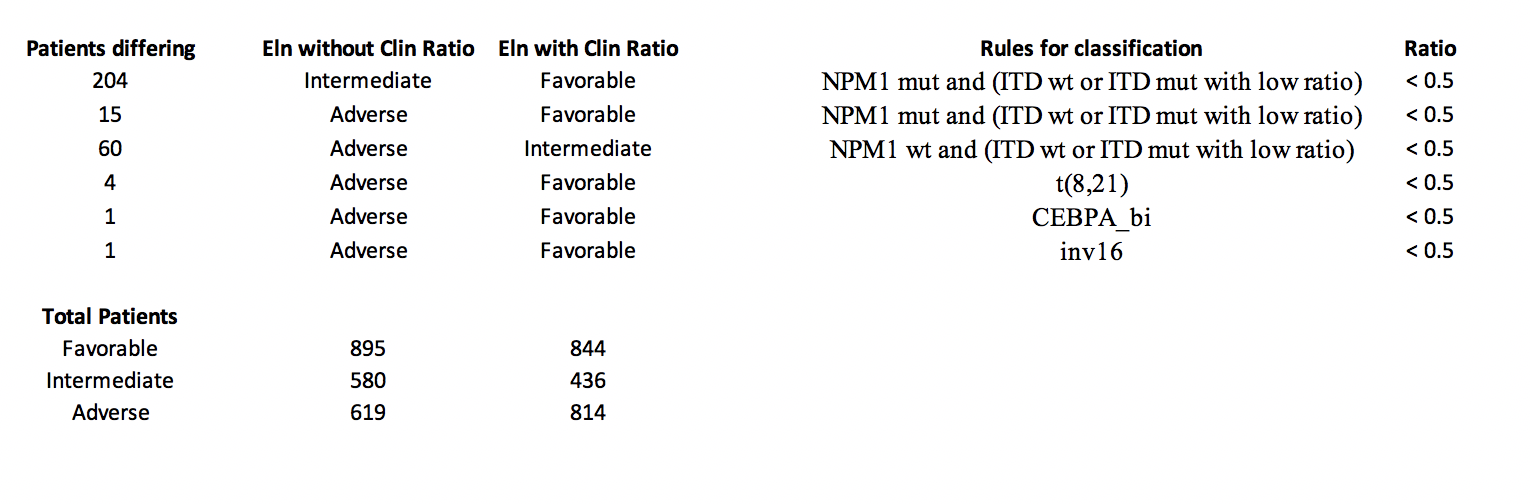

In [337]:
#From df_refined : keep ITD and new complex, from df_ITD keep Clin Ratio and from df_master remove complex.

df_final=pd.read_table("../../../data/updated_dataset/refined_components_updated.tsv",sep="\t",low_memory=False)
df_complete = df_final[['ITD','complex']].merge(pd.DataFrame(pd.DataFrame(df_m['Clin_Ratio'])),left_index=True,right_index=True)
df_master = pd.read_table("../../../data/initial_dataset/Master_04_10_2019.csv",sep=",",low_memory=False)
df_master.drop(['complex'],axis=1,inplace=True)
df_master.rename(columns={'eln_2017':'initial_eln_2017'},inplace=True)
df_master.set_index('data_pd',inplace=True)
df_complete = df_complete.merge(df_master,left_index=True,right_index=True)
df_complete.Clin_Ratio = df_complete[['wbc','bm_blasts','Clin_Ratio']].Clin_Ratio.interpolate(method='linear')
tmp = eln_2017_classification(df_complete)
tmp.rename(columns={"eln_2017": "eln_2017_without_ratio_rules"},inplace=True)
tmp = eln_2017_classification_ratio(tmp)
tmp.rename(columns={"eln_2017": "eln_2017_ratio"},inplace=True)
df_diff = tmp[tmp.eln_2017_ratio!=tmp.eln_2017_without_ratio_rules]
#df_diff.loc[:,'Classification rules']=np.nan
#df_diff.loc[(df_diff['Classification rules'].isnull()) & (df_diff.NPM1 == 0) & (df_diff.ITD == 1) & (df_diff.Clin_Ratio >= 50),'Classification rules'] ='NPM1 == 0 and ITD == 1 and high'
#df_diff.loc[(df_diff['Classification rules'].isnull()) & (df_diff.t_8_21==1),'Classification rules'] ='t_8_21'
#df_diff.loc[(df_diff['Classification rules'].isnull()) & (df_diff.inv_16 ==1),'Classification rules'] ='inv_16'
#df_diff.loc[(df_diff['Classification rules'].isnull()) & (df_diff.CEBPA_bi == 1),'Classification rules'] ='CEBPA_bi'
#df_diff.loc[(df_diff['Classification rules'].isnull()) & (df_diff.NPM1 == 1) & ((df_diff.ITD == 0) | ((df_diff.ITD == 1) & (df_diff.Clin_Ratio <50))),'Classification rules'] ='NPM1 == 1 and ITD == 0 or ITD ==1 and low'
#df_diff.loc[(df_diff['Classification rules'].isnull()) & (df_diff.RUNX1 ==1),'Classification rules'] ='RUNX1'
#df_diff.loc[(df_diff['Classification rules'].isnull()) & (df_diff.NPM1 == 0) & ((df_diff.ITD == 0) | ((df_diff.ITD == 1) & (df_diff.Clin_Ratio <50))),'Classification rules'] ='NPM1 == 0 and ITD == 0 or ITD ==1 and low' 
#df_diff.loc[(df_diff['Classification rules'].isnull()) & (df_diff.NPM1 == 1) & (df_diff.ITD == 1) &  (df_diff.Clin_Ratio >= 50),'Classification rules'] ='NPM1 == 1 and ITD == 1 and high'
print('There are '+ str(df_diff.shape[0]) +' differences in eln categories')
print(df_diff['rules'].value_counts())
print(tmp.eln_2017_ratio.value_counts())
print(tmp.eln_2017_without_ratio_rules.value_counts())
Image('eln_comparison.png')

In [366]:
#pd.DataFrame(tmp.eln_2017_ratio).to_csv("../../../data/updated_dataset/eln_ratio.tsv",sep='\t')


# STOP HERE

#### Merge dataframe master reduced with the mandatory columns for yoann's eln classification
#### with final incorporating the new translocation rules

### Yoann 's ELN Classification

In [104]:
import pandas as pd
df_final=pd.read_table("../../../data/updated_dataset/refined_components_updated.tsv",sep="\t",low_memory=False)
df_master = pd.read_table("../../../data/initial_dataset/Master_04_10_2019.csv",sep=",",low_memory=False)
df_master.drop('complex',axis=1,inplace=True)
df_master.set_index('data_pd',inplace=True)
merge = df_master.merge(pd.DataFrame(df_final[['ITD','complex']]), left_index=True, right_index=True)
merge.rename(columns={'eln_2017':'initial_eln_2017'},inplace=True)
merge_eln=eln_2017_classification(merge)
merge_eln.shape
#merge_eln[merge_eln.eln_2017!=merge_eln.initial_eln_2017][["initial_eln_2017","eln_2017"]]

(2094, 523)

In [29]:
df_final=pd.read_table("../../../data/updated_dataset/refined_components_updated.tsv",sep="\t",low_memory=False)
df_master = pd.read_csv("../../../data/initial_dataset/Master_04_10_2019.csv",sep=",",low_memory=False)
df_master.drop('Unnamed: 0', axis=1, inplace=True)
df_master.head()

,donor_id,data_pd,sample_pd.x,ASXL1,ASXL2,ASXL3,ATRX,BAGE3,BCOR,BRAF,...,MRD_relapse_status,CRdate,randDate_PB,CRDate_PB,relapseDate_PB,boneDate_PB,longCR_PB,FLT3_ITD_New,FLT3_ITD_Value_New,NoMatchFLT3
0,11-3496,PD20338c,PD20338c,0,0,0,0,0,0,0,...,1.0,1994-02-28,0,0,0,0,0,NaN,NaN,Missing
1,11-3807,PD20337c,PD20337c,0,0,0,0,0,0,0,...,1.0,NaN,0,0,0,0,0,NaN,NaN,Missing
2,11-3885,PD20336a,PD20336a,0,0,0,0,0,0,0,...,1.0,NaN,0,0,0,0,0,NaN,NaN,Missing
3,11-4052,PD20335c,PD20335c,0,0,0,0,0,0,0,...,1.0,NaN,0,0,0,0,0,NaN,NaN,Missing
4,11-4169,PD20334a,PD20334a,0,0,0,0,0,0,0,...,1.0,1997-07-15,0,0,0,0,0,NaN,NaN,Missing


In [11]:
def eln_2017_classification(df_merge):
    """
    This function builds the ELN 2017 classification of AML for the dataframe given in input. The classification is a new column labeled 'eln_2017'

    It supposes that the following are columns of the input:
        - t_8_21, inv_16, t_16_16, CEBPA_bi, NPM1, FLT3_ITD t_9_11, TP53, t_6_9, MLL, t_9_22, inv_3, t_3_3,
        minus5, del_5q, minus7, minus17, RUNX1 (or hotspots starting with RUNX1), ASXL1 (ibid), complex


    :param df_final:
    :return: pandas.DataFrame, copy of df_final with 'eln_2017' column
    """

    df = df_merge.copy(deep=True)
    df.loc[:, 'eln_2017'] = np.nan
    df.loc[(df.eln_2017.isnull()) & (df.t_9_11 == 1), 'eln_2017'] = 'intermediate'
    df.loc[(df.eln_2017.isnull()) & (df.complex == 1), 'eln_2017'] = 'adverse'
    df.loc[(df.eln_2017.isnull()) & (df.TP53 == 1), 'eln_2017'] = 'adverse'
    df.loc[(df.eln_2017.isnull()) & (df.t_6_9 == 1), 'eln_2017'] = 'adverse'
    if 'MLL_PTD' in df.columns.values:
        df.loc[(df.eln_2017.isnull()) & (df.MLL_PTD == 1), 'eln_2017'] = 'adverse'
    else:
        df.loc[(df.eln_2017.isnull()) & (df.MLL == 1), 'eln_2017'] = 'adverse'
    df.loc[(df.eln_2017.isnull()) & (df.t_9_22 == 1), 'eln_2017'] = 'adverse'
    df.loc[(df.eln_2017.isnull()) & (df.inv_3 == 1), 'eln_2017'] = 'adverse'
    df.loc[(df.eln_2017.isnull()) & (
                (df.minus5 == 1) | (df.del_5q == 1) | (df.minus7 == 1) | (df.minus17 == 1)), 'eln_2017'] = 'adverse'
    df.loc[(df.eln_2017.isnull()) & (df.NPM1 == 0) & (df.ITD == 1), 'eln_2017'] = 'adverse'  #yanis change for my dataset FLT3_ITD to new ITD

    df.loc[(df.eln_2017.isnull()) & (df.t_8_21 == 1), 'eln_2017'] = 'favorable'
    df.loc[(df.eln_2017.isnull()) & (df.inv_16 == 1), 'eln_2017'] = 'favorable'
    df.loc[(df.eln_2017.isnull()) & (df.CEBPA_bi == 1), 'eln_2017'] = 'favorable'
    df.loc[(df.eln_2017.isnull()) & (df.NPM1 == 1) & (df.ITD == 0), 'eln_2017'] = 'favorable' #yanis change for my dataset FLT3_ITD to new ITD

    # As we distinguish between hotspot mutations,  several columns may encode
    # for a gene mutation

    for col in [c for c in df.columns if c.startswith('RUNX1')]:
        df.loc[(df.eln_2017.isnull()) & (df[col] == 1), 'eln_2017'] = 'adverse'
    for col in [c for c in df.columns if c.startswith('ASXL1')]:
        df.loc[(df.eln_2017.isnull()) & (df[col] == 1), 'eln_2017'] = 'adverse'

    for col in [x for x in df.columns if (x.startswith('minus') or x.startswith('del'))]:
        df.loc[(df.eln_2017.isnull()) & (df[col] == 1), 'eln_2017'] = 'adverse'

    df.loc[(df.eln_2017.isnull()) & (df.NPM1 == 0) & (df.ITD == 0), 'eln_2017'] = 'intermediate'   #yanis change for my dataset FLT3_ITD to new ITD
    df.loc[(df.eln_2017.isnull()) & (df.NPM1 == 1) & (df.ITD == 1), 'eln_2017'] = 'intermediate'
    df.loc[df.eln_2017.isnull(), 'eln_2017'] = 'intermediate'

    return df

## I- Get the new ELN classification using Yoann 's rules

##### To do that, we need to use the original master dataframe because it contains all the necessary columns including all the translocations and copy numbers . 
##### We also add the new ITD rules from the df_final.

In [12]:
merge = df_master.merge(pd.DataFrame(df_final[['ITD']]), left_index=True, right_index=True)

##### In order to compare the eln classification previously done with Yoann's one including the new ITD rules ,
##### we rename the column eln 2017 coming from the master dataframe as initial eln.

In [13]:
merge.rename(columns={'eln_2017':'initial_eln_2017'},inplace=True)
merge.shape

(2150, 521)

### Important to note that from now on, we do not use the column FLT3_ITD because we have new rules in the column ITD

#### We incorporate the function for the new eln classification

In [14]:
merge_eln=eln_2017_classification(merge)
merge_eln.shape

(2150, 522)

## II- Compare it with the initial_eln classifcication

In [15]:
df_diff = merge_eln[merge_eln.eln_2017!=merge_eln.initial_eln_2017]
print ("There are "+str(df_diff.shape[0]) + " rows differing")

There are 67 rows differing


### Let's look at the activated mutations for those rows and the rules used for the new eln classification

In [17]:
tmp=copy.copy(df_diff)
tmp.drop(columns=[
                    'ahd','secondary','perf_status','gender','ahd', 'os_status',
                  'DEADStatus','RFSStatus','MRD_Status','MRD_relapse_status','cod',
                    'intense','cr','RelapseCIStatus','dic_13_21','acmcar','trial.x',
                    'acmarr','acmoth','acmhvd','acmibd','acminf','acmhepmil','acmrhe',
                    'acmpsy','acmpri','acmobe','acmdia'
                  ]
                     ,inplace=True)
l=[]
for row in tmp.index:
    l.append(list(tmp.ix[row][tmp.ix[row]==1].index))

#### Positive mutation

In [19]:
df_diff.loc[:,'positive mutation']=l

#### Rules used for ELN Classification

In [20]:
df_diff.loc[:,'Classification rules']=np.nan
df_diff.loc[(df_diff['Classification rules'].isnull()) & (df_diff.NPM1 == 0) & (df_diff.ITD == 1),'Classification rules'] ='NPM1 == 0 and ITD == 1'
df_diff.loc[(df_diff['Classification rules'].isnull()) & (df_diff.t_8_21==1),'Classification rules'] ='t_8_21==1'
df_diff.loc[(df_diff['Classification rules'].isnull()) & (df_diff.inv_16 ==1),'Classification rules'] ='inv_16 ==1'
df_diff.loc[(df_diff['Classification rules'].isnull()) & (df_diff.CEBPA_bi == 1),'Classification rules'] ='CEBPA_bi == 1'
df_diff.loc[(df_diff['Classification rules'].isnull()) & (df_diff.NPM1 == 1) & (df_diff.ITD == 0),'Classification rules'] ='NPM1 == 1 and ITD == 0'
df_diff.loc[(df_diff['Classification rules'].isnull()) & (df_diff.RUNX1 ==1),'Classification rules'] ='RUNX1 ==1'
df_diff.loc[(df_diff['Classification rules'].isnull()) & (df_diff.NPM1 == 0) & (df_diff.ITD == 0),'Classification rules'] ='NPM1 == 0 and ITD == 0'
df_diff.loc[(df_diff['Classification rules'].isnull()) & (df_diff.NPM1 == 1) & (df_diff.ITD == 1),'Classification rules'] ='NPM1 == 1 and ITD == 1'

In [21]:
print(df_diff.shape)
df_diff[['initial_eln_2017','eln_2017','positive mutation','Classification rules']].head()

(67, 524)


,initial_eln_2017,eln_2017,positive mutation,Classification rules
data_pd,,,,
PD20320a,intermediate,favorable,"[FLT3_ITD, NPM1, TET2]",NPM1 == 1 and ITD == 0
PD20312a,intermediate,favorable,"[CEBPA_mono, FLT3_ITD, NPM1, TET2]",NPM1 == 1 and ITD == 0
PD20306a,adverse,intermediate,"[DNMT3A, FLT3_ITD]",NPM1 == 0 and ITD == 0
PD20253a,intermediate,favorable,"[DNMT3A, FLT3_ITD, NPM1, NRAS_p.G12_13, TET2]",NPM1 == 1 and ITD == 0
PD20251c,adverse,intermediate,"[DNMT3A, FLT3_ITD, IDH2_p.R140]",NPM1 == 0 and ITD == 0


In [564]:
print(df_diff.shape)
df_diff[['initial_eln_2017','eln_2017','positive mutation','Classification rules']].head()

(67, 524)


,initial_eln_2017,eln_2017,positive mutation,Classification rules
data_pd,,,,
PD20320a,intermediate,favorable,"[FLT3_ITD, NPM1, TET2]",NPM1 == 1 and ITD == 0
PD20312a,intermediate,favorable,"[CEBPA_mono, FLT3_ITD, NPM1, TET2]",NPM1 == 1 and ITD == 0
PD20306a,adverse,intermediate,"[DNMT3A, FLT3_ITD]",NPM1 == 0 and ITD == 0
PD20253a,intermediate,favorable,"[DNMT3A, FLT3_ITD, NPM1, NRAS_p.G12_13, TET2]",NPM1 == 1 and ITD == 0
PD20251c,adverse,intermediate,"[DNMT3A, FLT3_ITD, IDH2_p.R140]",NPM1 == 0 and ITD == 0


In [576]:
df_diff[['initial_eln_2017','eln_2017','positive mutation','Classification rules']].to_csv("differences.csv",sep=",")

## III- Add the new ELN classification in the df final with the other translocation rules dataset

In [565]:
df_final.shape

(2150, 152)

In [567]:
df_final_eln = df_final.merge(pd.DataFrame(merge_eln[['eln_2017']]),left_index=True,right_index=True)

In [571]:
print(df_final_eln.shape)
df_final_eln.head()

(2150, 153)


,sample_pd,ASXL1,ASXL2,ASXL3,ATRX,BAGE3,BCOR,BRAF,CBFB,CBL,...,t_8_16,t_8_17,t_8_21,t_9_11,t_9_13,t_9_17,t_9_22,complex,others_transloc,eln_2017
data_pd,,,,,,,,,,,,,,,,,,,,,
PD20338c,PD20338c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,favorable
PD20337c,PD20337c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,intermediate
PD20336a,PD20336a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,adverse
PD20335c,PD20335c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,favorable
PD20334a,PD20334a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,adverse


#### Let's save it

In [572]:
df_final_eln.to_csv("../../../data/updated_dataset/modif_final_eln.csv",sep=",")